출처: https://dacon.io/competitions/official/235590/codeshare/949?page=1&dtype=vote

1. Feature engineering

먼저, 코로나19로 인한 사망 위험을 높이는데 기여한 확진자들의 행동 특성 이 무엇이었는지 분석해보겠습니다. 이때 '행동과 관련된 특성/요인'이란, 확진자들의 통제 하에 있는 특성/요인들로 확진자들의 선택에 따라 값이 달라지는 특성을 의미합니다. 확진자들이 어떤 행동을 보였느냐를 기반으로 비슷한 행동 패턴을 보인 확진자들을 파악하기 위해 Cluster 모델을 활용해 확진자들을 행동 유형에 따라 구분지었습니다. 모델에 활용한 행동 요인과 관련된 특성들은 모두 네 가지 입니다

1) 감염 경로 유형
2) 유동성
3) 접촉 정도
4) 확진받기까지 걸린 시간

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings  
warnings.filterwarnings('ignore')

In [152]:
patient = pd.read_csv('/content/drive/MyDrive/colab_data/PatientInfo.csv')
patient.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,NaN,31.00,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released


In [153]:
print(patient.shape, len(patient.patient_id.unique()))  

(3388, 18) 3388


PatientInfo 데이터 내에 총 3388명의 확진자가 있습니다. rows와 patient_id의 독립적인 개수가 같은 것으로 보아 중복 id는 없는 것으로 보입니다. 그럼 모델링에 활용할 변수들을 준비하는 과정을 시작하겠습니다.

1.1. 감염 경로 유형 (Infection route)

감염 경로 유형의 특성은 코로나 바이러스에 어떤 경로로 감염되었는지를 보여주는 특성입니다. 감염 경로 유형은 집단 모임에 참석했거나 해외에서 입국하는 등 사람의 행동에 따라 값이 달라지므로 행동적인 특성으로 볼 수 있습니다. PatientInfo의 infection_case가 이 정보를 담고 있으나 아래 셀을 보시면, infection_case의 독립된 값이 모두 24개인 것을 볼 수 있습니다.

In [154]:
data = patient.copy()

In [155]:
print('the number of unique values in infection_case:',len(data['infection_case'].unique())) 
data['infection_case'].unique()

the number of unique values in infection_case: 24


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Milal Shelter', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

일반적으로 모델링에서 24개의 값을 가진 변수를 그대로 활용한다면 의미있는 결과를 내기는 어려울 것입니다. 물론 24개의 값이 모두 특별한 의미를 가지고 있다면 상황은 달라집니다. 하지만 infection_case 의 24개의 값들이 실제로 얼마나 존재하는지 높은 순으로 정렬한 다음의 차트를 보면, 첫 세개의 값(환자와의 직접 접촉-'contact with patient', 해외유입-'overseas inflow', 알수없음-'etc')을 제외한 나머지 각각은 큰 비중을 차지하지 않는 것을 볼 수 있습니다.

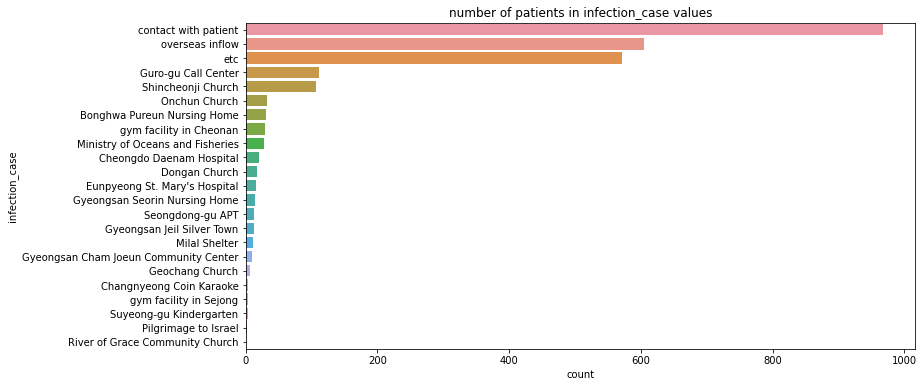

In [156]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)

plt.figure(figsize = (12,6))
plt.title('number of patients in infection_case values')
sns.barplot(y = 'infection_case', x= 'count', data = g)
display()

'어디'에서 감염되었느냐를 보는 것이 분석의 목적이었다면, 모든 값의 사용을 고려하는 것이 맞을 것입니다. 하지만 이번 분석의 목적은 감염의 '어떤' 경로가 사망에 이르는 위험성을 가지고 있었느냐를 밝히는 것입니다. 그렇다면 '어디'라는 구체적 장소를 그대로 사용하는 것보다 이 변수를 활용해 '어떤' 방식으로 감염되게 되었는지를 만들어내 모델에 활용하는 것이 필요합니다. 첫 번째 세개의 값, '감염자와의 직접 접촉(contact with patient)', '해외유입(overseas inflow)', '알수없음(etc)'은 그 자체의 의미를 살려두고, 나머지는 집단 감염에 따른 세부적 사례를 나타내는 것으로 한데 묶어 '집단 감염(group)'의 값을 부여합니다.

하지만 이때 '집단 감염'을 정의하는데에는 주의를 필요로 합니다. 위의 차트를 보면 "River of Grace Community Church"는 교회에서 감염된 것으로 보아 '집단 감염'일 가능성이 있지만, 실제로 해당 값을 갖는 확진자는 단 한명에 불과합니다. 데이터 내에 한 명만이 존재하는 사례를 "집단 감염"이라고 보기는 어려울 것입니다. 마찬가지로 소수의 인원이 속한 값은 값 자체로는 집단으로 보일지 몰라도 실제로는 집단 감염이라고 보기 어렵습니다. 따라서 해당 값을 가진 확진자들의 수가 최소 5명 이상일 때에만 '집단 감염(group)' 값을 부여하고, 나머지는 활용하지 않습니다.

먼저 5명 미만의 infection_case를 추출해 확인합니다.

In [157]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = pd.DataFrame(g)

infection_case_less_than_5 = g[g['patient_id'] < 5].index.tolist()
g[g.index.isin(infection_case_less_than_5)] #isin 함수는 무슨 뜻이지?

,patient_id
infection_case,
Changnyeong Coin Karaoke,4
Pilgrimage to Israel,2
River of Grace Community Church,1
Suyeong-gu Kindergarten,3
gym facility in Sejong,4


위의 리스트에 속하는 확진자들을 걸러냅니다. 총 14명의 확진자가 제거됩니다.

In [158]:
print('original data shape:', data.shape)
data = data[~(data['infection_case'].isin(infection_case_less_than_5))] #~는 무슨뜻? 제거한다는 뜻인가?
print('data shape after slicing: ', data.shape)

original data shape: (3388, 18)
data shape after slicing:  (3374, 18)


다음으로 위의 infection_case의 독립적 값에 존재하던 nan를 어떻게 처리할지를 결정합니다. 가장 간단한 방법은 nan값을 가진 확진자는 모두 제거하는 것일 겁니다. 하지만 아래 infection_csae의 nan의 수는 768개(약 23%)로 꽤 많은 비중을 차지하는 것을 볼 수 있습니다.

In [159]:
data[data['infection_case'].isna()].shape

(768, 18)

무엇보다 infection_case가 nan이라는 것은 그야말로 해당 확진자의 감염 경로를 "알 수 없다"는 의미이고, 해당 값은 infection_case의 값 중 하나인 etc가 의미하는 바와 같습니다. 따라서 nan은 etc와 같은 카테고리 - "알 수 없음(unknown)"으로 정의합니다.

In [160]:
def categorisation(x):
    
    '''
    categorises infection types
    '''
    
    if x == 'overseas inflow':
        y = 'overseas'
    elif x == 'contact with patient': 
        y = 'individual'
    elif (x == 'etc') | (pd.isna(x)):
        y = 'unknown'
    else: 
        y = 'group' 
    
    return y 

data['infection'] = data['infection_case'].apply(lambda x: categorisation(x))# apply랑 람다함수 응용 신기방기
print(data.shape)
data.head()

(3374, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,NaN,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,NaN,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


In [161]:
g = data.groupby(['infection'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)
g

,infection,count
0,group,462
1,individual,968
2,overseas,604
3,unknown,1340


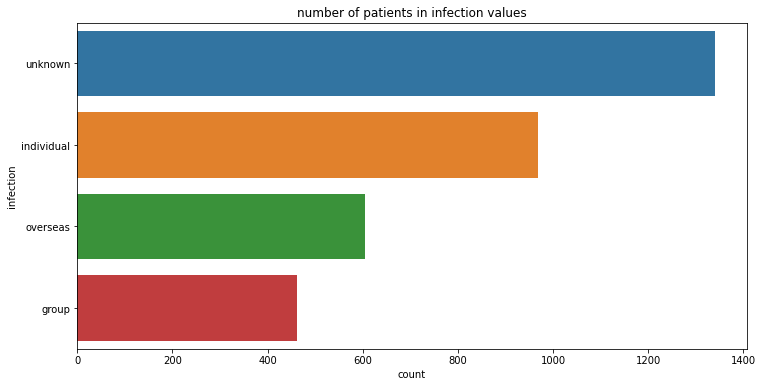

In [162]:
g = g.sort_values('count', ascending = False)

plt.figure(figsize = (12,6))
sns.barplot(y = 'infection', x= 'count', data = g)
plt.title('number of patients in infection values')
display()

이상, PatientInfo의 infection_case를 재가공하여 '집단감염(group)', '개인감염(individual)', '해외유입(overseas)', '밝혀지지않음(unknown)'으로 구성된 "감염 경로 유형"의 특성이 생성되었습니다.

1.2. 유동성 (Mobility level)

유동성은 확진자들이 얼마만큼의 이동을 보였는지를 나타내는 특성입니다. 예를들어 친구를 만나러 카페에 간 사람과 가지 않고 집에 있던 사람은 유동성에서 다른 값을 갖게 될 것입니다. 따라서 유동성은 확진자들의 행동 유형을 구분지을 수 있는 행동적 특성의 하나로써 모델에 활용합니다. 유동성의 특성은 확진자들이 다녀갔던 장소에 대한 정보를 나타내는 PatientRoute의 type에 기반하여 생성됩니다.

In [163]:
route = pd.read_csv('/content/drive/MyDrive/colab_data/PatientRoute.csv')
print(route.shape)
route.head()

(6714, 8)


,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.00,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.62,126.72
1,1000000001,2.00,2020-01-24,Seoul,Jung-gu,hospital,37.57,127.01
2,1000000002,5.00,2020-01-25,Seoul,Seongbuk-gu,etc,37.59,127.02
3,1000000002,5.00,2020-01-26,Seoul,Seongbuk-gu,store,37.59,127.02
4,1000000002,5.00,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56,127.03


In [164]:
print('the number of unique values in type:', len(route['type'].unique()))
route['type'].unique()

the number of unique values in type: 24


array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'lodging', 'academy', 'university', 'administrative_area_level_1'],
      dtype=object)

In [165]:
route[route['type'].isna()].shape

(0, 8)

먼저 데이터에는 총 24가지의 독립적인 장소들이 존재하고 있고, 해당 변수에는 결측치가 없는 것을 확인하였습니다. 이 장소들을 기반으로 각 확진자들의 '유동성'에 대한 특성을 추출합니다. 먼저 방문한 장소들을 기반으로 해당 이동이 필수적(essential)이었는지 부수적(non-essential)이었는지를 구분하고, 각 확진자 별로 필수적/부수적 이동을 얼마나 하였는지 그 횟수를 구합니다.

필수적/부수적 이동을 구별하고자 먼저 24가지의 장소들을 세부 카테고리로 구분하였습니다.

In [166]:
## categories
leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon',
          'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

위 카테고리 중에서 '필수 교육(essential_edu)/필수 행정(essential_admin)/생활 필수(necessity)/의료(medical)' 카테고리를 필수적 이동(essential)으로 구분하고, 나머지는 부수적 이동(non-essential)으로 정의합니다.

In [167]:
essential = essential_edu + essential_admin + necessity + medical 

def type_group_essen(x): 
     
    group = None
    if x in essential: 
        group = 'essential'
    else:
        group = 'non-essential' 
    return group 

route['route_group_essential'] = route['type'].apply(lambda x: type_group_essen(x)) 
route = route[['patient_id', 'type', 'route_group_essential']]
route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


In [168]:
route['route_value'] = 1 #이런식으로 칼럼을 하나 추가해서 갯수를 셀 수 있구나...
g = pd.DataFrame(route.groupby(['patient_id', 'route_group_essential'])['route_value'].count().unstack()) #unstack 함수가 뭐지?
g

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,NaN,2.00
1000000004,1.00,NaN
1000000005,1.00,NaN
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


In [169]:
g_unstack= pd.DataFrame(route.groupby(['patient_id', 'route_group_essential'])['route_value'].count()) #unstack 함수가 뭐지?
g_unstack #아하!

route_value
patient_id route_group_essential             
1000000001 essential                        1
           non-essential                    1
1000000002 essential                        9
           non-essential                    4
1000000003 non-essential                    2
...                                       ...
6100000088 non-essential                   19
6100000089 essential                        1
           non-essential                    1
6100000090 essential                        3
           non-essential                    4

[1968 rows x 1 columns]

간간이 nan의 값이 보이는 것을 볼 수 있습니다. raw data에서 type은 결측치가 없었고 위의 테이블은 이를 기반으로 essential/non-essential의 횟수를 구한 것으로, 위 테이블의 nan은 해당 확진자가 해당 이동(essential 또는 non-essential)을 하지 않았음을 의미합니다. 따라서 이 경우, nan의 값은 '이동을 하지 않았음'을 의미하는 0으로 채워줍니다.

In [170]:
g.fillna(0, inplace = True)
g.reset_index(inplace = True)
g = g[['patient_id', 'essential', 'non-essential']]
g.head()

route_group_essential,patient_id,essential,non-essential
0,1000000001,1.00,1.00
1,1000000002,9.00,4.00
2,1000000003,0.00,2.00
3,1000000004,1.00,0.00
4,1000000005,1.00,0.00


확진자의 유동성을 나타내는 확진자별 필수적/부수적 이동 횟수 테이블이 완성되었습니다. 이를 전체 데이터에 확진자별로 더해주어 모델에 활용할 수 있도록 합니다.

In [171]:
data = data.merge(g, left_on = 'patient_id', right_on = 'patient_id', how = 'left')
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,...,NaN,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,NaN,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,...,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00


In [172]:
print(data.shape)
data[(data['essential'].isna()) | (data['non-essential'].isna())].shape

(3374, 21)


(2170, 21)

안타깝게도 현재 데이터가 보유한 3374 명의 확진자들이 모두 essential/non-essential 특성을 갖고있지는 않습니다.essential/non-essential의 특성을 갖지 않은 케이스는 모두 2170명(약 64%)로 굉장히 많은 부분을 차지하고 있습니다. 이들이 해당 이동을 하지 않았기 때문에 route의 데이터가 없었을 것이라 가정하고, "이동하지 않았음"을 의미하는 0의 값을 줄 수도 있습니다. 하지만 이들이 실제로 이동을 하지 않았기 때문에 route 데이터에 존재하지 않았는지는 확신할 수 없습니다. 64%에 해당하는 많은 사람들이 어떤 이동도 하지 않았다는 것고 단정하기는 어렵습니다. 되려 이동은 하였으나 기록되지 않았을 가능성이 더 높습니다. 이들의 값을 추정할 수 있는 데이터나 다른 근거가 더이상 없기 때문에 essential/non-essential 특성을 갖지 않는 확진자들은 모델에 활용할 수 없습니다. 따라서 이들은 모두 제거합니다.

In [173]:
print('original data shape:', data.shape)
data = data[(data['essential'].notna()) & (data['non-essential'].notna())] 
print('data shape after removing missing values in essentail/non-essential:', data.shape)

original data shape: (3374, 21)
data shape after removing missing values in essentail/non-essential: (1204, 21)


essential/non-essential 유동성을 나타내는 특성이 완성되었고, 해당 특성을 가진 1204 명의 확진자가 표본에 남게 되었습니다.



1.3. 접촉 정도 (Number of contacts)

위의 유동성과 더불어 확진자들의 행동 유형을 파악할 수 있는 요인 중 하나로 '접촉 정도'를 들 수 있습니다. 유동성은 확진자들이 얼마나 이동을 하였는지를 대표하는 특성이고, 같은 정도의 유동성을 보이는 사람들도 접촉 정도에서는 다른 값을 가지게 됩니다. 예를들어 식당이라는 같은 장소로 같은 횟수의 이동을 한 사람들 중, 혼자 식사를 하러 간 사람과 친구를 만나러 간 사람은 접촉 정도에서 다른 값을 갖게 될 것입니다. 이에따라 확진자들의 행동 유형을 구분짓는 특성 중 하나로 접촉 정도를 활용하며, 접촉 정도는 확진자들의 사회성 정도를 의미합니다. 접촉 정도의 특성은 PatientId의 'contact_number'를 활용합니다.

먼저 contact_number의 분포를 보겠습니다.

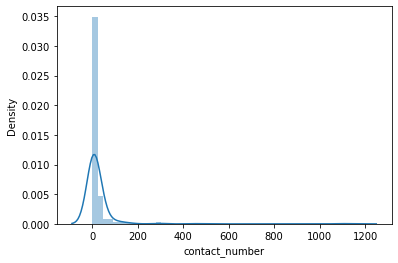

In [174]:
sns.distplot(data['contact_number'])
display()

In [175]:
data['contact_number'].describe()

count    332.00
mean      24.27
std       95.07
min        0.00
25%        2.00
50%        5.00
75%       17.25
max     1160.00
Name: contact_number, dtype: float64

contact_number의 분포를 보면 값을 가진 확진자들 332명의 확진자들은 평균적으로 24명의 사람과 접촉한 것으로 보입니다. 접촉이 많은 사람일수록 상대적으로 훨씬 많은 접촉을 한 것으로 보입니다.

특히 접촉 횟수의 최대값을 가진 확진자를 살펴보면,

In [176]:
data[data['contact_number'] == 1160] # 와 개신기함

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
764,1200000031,31.00,female,1959.00,60s,Korea,Daegu,NaN,NaN,Shincheonji Church,...,NaN,1160.00,NaN,2020-02-18,NaN,NaN,isolated,group,11.00,5.00


코로나 바이러스 확산 초창기 확진자 수를 기하급수적으로 늘리는데 기여한 '31번 확진자'인 것을 볼 수 있습니다.

극단적 값을 갖는 확진자들을 outlier로 봐야하는지에 조심스러운 해석이 필요합니다. 특히나 이번 분석의 주요 특성 중 하나인 '감염 경로'에 '집단감염'이 있고, 극단적인 접촉 정도를 가진 확진자들은 집단감염의 사례였을 가능성이 있습니다. 또는 극단적 값을 가진 사례가 '개인감염'이었다면, 이는 집단감염과 구분지을 수 있는 척도가 됩니다. 따라서 contact_number의 값을 모두 활용하기로 합니다.

다만 그 값을 갖지 않는 사람들은 위의 '유동성'과 마찬가지로 "접촉이 없었다"고 확신할 근거가 없습니다. 따라서 접촉 횟수의 값이 없는 사람들은 모두 제거합니다.

In [177]:
print('original data shape:', data.shape)
data = data[data['contact_number'].notna()]
print('data shape after removing missing values in contact_number:', data.shape)
#데이터 갯수가 이렇게 줄어든게 신기했음, 내가 하는 일도 원본 주가 시계열 데이터는 10만개였지만, 결국 분석대상이 되는 트레이딩 데이터는 4000개도 되지 않았거든...

original data shape: (1204, 21)
data shape after removing missing values in contact_number: (332, 21)


현재까지 데이터에 남은 확진자는 총 332명입니다.

1.4. 확진받기까지 걸린 시간 (Diagnosis time)

확진받기까지 걸린 시간이란 증상이 처음 발현되고 얼마나 빨리 코로나19 확진을 받았는지를 의미합니다. 확진을 받기까지 걸린 시간은 사람의 선택/행동에 따라 값이 달라질 수 있는 특성이기 때문에 행동 특성이라고 볼 수 있습니다. 예를들어 진단 검사를 얼마나 신속하게 받으러 갔는지, 코로나 진단 검사 의료진이 코로나 바이러스의 가능성을 얼마나 빨리 발견해 얼마나 신속하게 검사를 받게 했는지에 따라 그 값이 달라질 수 있습니다. 확진받기까지 걸린 시간은 ‘증상이 처음 시작된 날(symptom_onset_date)’과 ‘확진 날짜(confirmed_date)’ 사이의 차이로 정의됩니다.

먼저 활용할 변수의 결측치를 확인합니다.

In [178]:
print('data shape:', data.shape)
print('missing values in symptom_onset_date:', data[data['symptom_onset_date'].isna()].shape)
print('missing values in confirmed_date:', data[data['confirmed_date'].isna()].shape)

data shape: (332, 21)
missing values in symptom_onset_date: (208, 21)
missing values in confirmed_date: (0, 21)


총 332명의 확진자 중, 증상이 발현한 날짜(symptom_onset_date)에 208개의 결측치가 존재합니다. 코로나19는 다른 바이러스와 달리 바이러스를 보유하고 있더라도 증상을 보이지 않을 수 있는 것으로 유명합니다. 따라서 symptom_onset_date가 결측치인 경우, 증상이 나타나지 않았기 때문에 결측치로 기록되었을 가능성이 있습니다. 이 경우 확진받기까지 걸린 시간은 0으로 상정하고 증상이 나타난 직후 확진을 받았다고 가정할 수도 있습니다. 하지만 결측치 중에 증상이 나타났으나 기록이 없는 경우도 배제할 수는 없습니다. 안타깝게도 여기에서 더 나아갈 데이터와 근거가 부족합니다. 이에따라 증상이 발현한 날짜의 정보가 없는 확진자들은 모두 제거합니다.

In [179]:
### Cleaning symptom onset date
data[data['symptom_onset_date'] == ' ']
data['symptom_onset_date'] = np.where((data['symptom_onset_date'] == ' '), None, data['symptom_onset_date']) #무슨 뜻이지?

### Remove missing values in symptom_onset_date
print('original data shape: ', data.shape)
data = data[data['symptom_onset_date'].notna()]
print('data excluding missing values in symptom_onset_date: ', data.shape)

original data shape:  (332, 21)
data excluding missing values in symptom_onset_date:  (124, 21)


결측치 208개가 모두 제거되어 데이터에는 124명의 확진자가 남았습니다. 이들을 대상으로 확진받기까지의 시간을 구할 수 있도록 두 변수를 date format으로 변환하여줍니다.

In [180]:
### Define time that lapsed between the onset of COVID-19 symptoms and the official COVID-19 diagnosis

## Convert str into date func.
def convert_date(x):
    x = pd.datetime.strptime(x, '%Y-%m-%d').date()
    return x

## convert symptom_onset_date/confirmed_date into date format
data['symptom_onset_date'] = data['symptom_onset_date'].apply(lambda x : convert_date(x))
data['confirmed_date'] = data['confirmed_date'].apply(lambda x: convert_date(x))
# 와 진짜 apply lambda 개신기함...

data.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,NaN,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,NaN,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,1000000013.00,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00


date format으로 변환된 symptom_onset_date와 confirmed_date 사이의 날짜 차이를 구해줍니다. 일단 날짜 차이(e.g. 10 days)를 구하고 나면, date format은 그 자체로는 모델에 활용할 수 없기 때문에 모델에서 활용할 수 있도록 integer로 다시 변환하여 마지막 변환된 값을 'days'라는 이름으로 저장합니다.

In [181]:
## find time lapsed between symptom_onset_date and confirmed_date
data['days_notice'] = data['confirmed_date'] - data['symptom_onset_date'] 
data['hours_notice'] = data['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
data['days'] = data['hours_notice'].apply(lambda x: int(x/24))
data.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential,days_notice,hours_notice,days
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00,1 days,24.00,1
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00,4 days,96.00,4
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00,10 days,240.00,10


이상으로 모델에 활용할 네 가지의 행동 특성 1) 감염 경로 유형, 2) 유동성, 3) 접촉 정도, 4) 확진받기까지 걸린 시간의 제작을 모두 완료하였습니다.



2. Building cluster model


2.1. Feature transformation

우선 전체 데이터셋에서 위에서 제작한 행동 특성들을 추출해 모델에 활용합니다.

In [182]:
data_ = data[['patient_id', 
              'days', 
              'contact_number', 
              'essential', 'non-essential', 
              'infection']]
data_.reset_index(drop = True, inplace = True)
print(data_.shape)
data_.head()

(124, 6)


,patient_id,days,contact_number,essential,non-essential,infection
0,1000000001,1,75.00,1.00,1.00,overseas
1,1000000004,4,9.00,1.00,0.00,overseas
2,1000000014,10,27.00,10.00,3.00,individual
3,1000000015,8,8.00,6.00,3.00,group
4,1000000302,1,8.00,1.00,0.00,overseas


2.1.1. transformation of categorical variable

유동성 특성(essential/non-essential)과 확진받기까지 걸린 시간(days), 접촉 정도(contact_number)는 numeric 변수이지만 감염 경로 유형은 categorical 변수인 것을 볼 수 있습니다. 이를 OneHotEncoder를 활용하여 numeric 변수로 변환하고 모델에 활용합니다.

In [183]:
encoder = OneHotEncoder(categories = 'auto', sparse=False) #sparse=False는 뭐지?
encoder.fit(np.array(data_['infection']).reshape(-1, 1)) #reshape(-1,1)?
inf_dummies = encoder.transform(np.array(data_['infection']).reshape(-1, 1))
dummies = pd.DataFrame(inf_dummies.astype(int), columns = ['infection_' + x for x in encoder.categories_[0]]) #오..이러게 칼럼명도 변경가능하구나

data_ = data_.join(dummies)
print(data_.shape)
data_.head()

(124, 10)


,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown
0,1000000001,1,75.00,1.00,1.00,overseas,0,0,1,0
1,1000000004,4,9.00,1.00,0.00,overseas,0,0,1,0
2,1000000014,10,27.00,10.00,3.00,individual,0,1,0,0
3,1000000015,8,8.00,6.00,3.00,group,1,0,0,0
4,1000000302,1,8.00,1.00,0.00,overseas,0,0,1,0


2.1.2. scaling

이제 데이터셋에는 모두 numeric 변수들만이 존재합니다. 이들 값의 범위(scale)가 모두 다르므로 scaler를 활용하여 scaling을 해줍니다. 여기서 활용할 scaler는 StandardScaler이며, 모델에 활용할 수 있도록 array format으로 변경하여줍니다.



In [184]:
inputs = ['days', 
          'essential', 'non-essential', 'contact_number',
          'infection_group', 'infection_individual', 'infection_overseas', 'infection_unknown']

X = data_[inputs]
print(X.shape)
X.head()

(124, 8)


,days,essential,non-essential,contact_number,infection_group,infection_individual,infection_overseas,infection_unknown
0,1,1.00,1.00,75.00,0,0,1,0
1,4,1.00,0.00,9.00,0,0,1,0
2,10,10.00,3.00,27.00,0,1,0,0
3,8,6.00,3.00,8.00,1,0,0,0
4,1,1.00,0.00,8.00,0,0,1,0


In [185]:
X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)  

모델에 활용할 inputs이 모두 완성되었습니다. 완성된 inputs을 PCA 모델을 활용, 모든 features를 2 dimensions으로 압축하여 행동 특성에 따른 확진자들의 포인트가 어떻게 분포하는지 살펴보겠습니다.

2.2. Dimensionality reduction using PCA

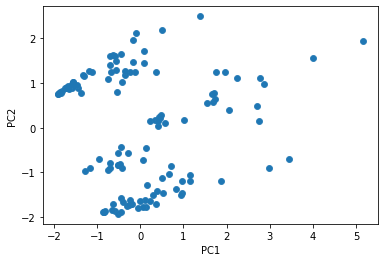

In [186]:
pca = PCA(n_components = 2) # categorical 변수를 어떻게 PCA하는거지?
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

ax = sns.scatterplot(x='PC1', y='PC2', data = principalDF) 
sns.regplot(x=principalDF['PC1'], y=principalDF['PC2'], fit_reg=False)

display()

위의 PCA 차트를 보면 3-4개의 clusters가 파악될 것을 예상할 수 있습니다.

2.3. Clustering

가장 optimal한 clusters의 개수를 확인하기 위해 각 cluster 개수 별 sum of squared error를 구해 보겠습니다.

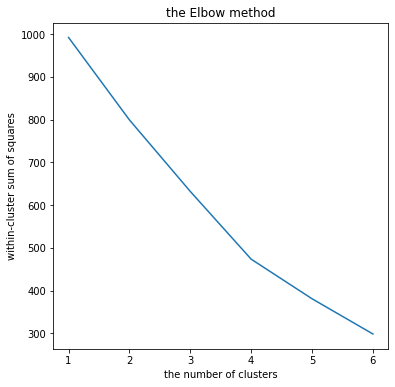

In [187]:
cluster_range = range(1,7) #KMeans의 SSE는 어떻게 구하는거지?
cluster_errors = []
for n in cluster_range:
    cluster = KMeans(n)
    cluster.fit(X)
    cluster_errors.append(cluster.inertia_)

plt.figure(figsize = (6,6))
plt.plot(cluster_range, cluster_errors)
plt.title('the Elbow method')
plt.xlabel('the number of clusters')
plt.ylabel('within-cluster sum of squares')
display()

위의 차트를 보면, cluster의 개수가 4개 이상일 때 에러가 감소하는 폭이 줄어든 것을 확인할 수 있습니다. 이에따라 4를 optimal number of clusters로 결정하고 그대로 cluster 분석을 수행할 수도 있습니다. 하지만 여기서는 4개 이상일 때 어떤 현상이 나타나는지 먼저 확인해보도록 하겠습니다.

Custering 모델에 인풋을 넣고 확진자들을 4개의 clusters로 구분해보겠습니다.

In [188]:
km = KMeans(n_clusters = 4)
km.fit(X)

centroids = km.cluster_centers_ 
labels= km.labels_
data_['label'] = labels

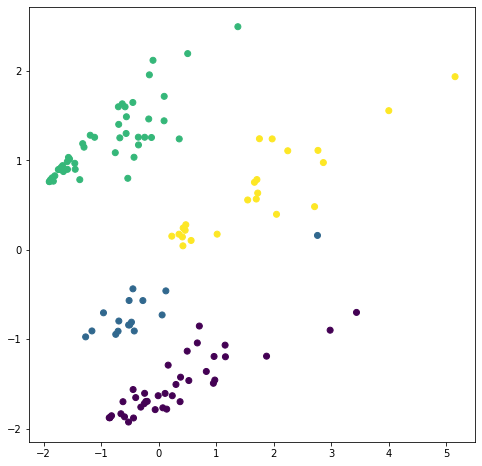

In [189]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

display()

위의 결과를 보면 나머지 네 개의 clusters는 근처에 위치한 포인트들이 그룹지어진 반면, 한 개의 포인트만 구분한 cluster가 있는 것을 볼 수 있습니다. 이 포인트는 다른 네 개의 clusters와 행동 패턴을 공유하지 않기 때문에 따로 분류되지만, 하나의 포인트만 속해 cluster라고 보기는 어렵습니다. 그보다는 다른 clusters와 행동 패턴을 공유하지 않는 outlier라고 봐야할 것입니다. 따라서 위의 포인트를 찾아내 제거하고, 4개를 optimal number of cluster로 모델을 다시 돌려보겠습니다.

In [190]:
data_.groupby(['label'])['patient_id'].count()

label
0    39
1    16
2    46
3    23
Name: patient_id, dtype: int64

In [191]:
data_ = data_[data_['patient_id'] != 1300000001]
data_.reset_index(drop = True, inplace = True)

X = data_[inputs]
print('X shape:', X.shape) 

X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

km = KMeans(n_clusters = 4)
km.fit(X)

centroids = km.cluster_centers_ 
labels= km.labels_
data_['label'] = labels

X shape: (123, 8)


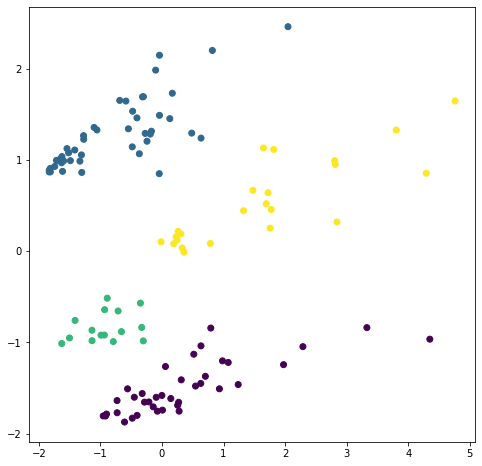

In [192]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

display()

Cluter 분석 결과, 행동 패턴으로 구분되는 확진자들의 유형 네 가지 가 파악되었습니다.

In [193]:
#### 이후의 코드의 경우 레퍼런스한 곳에서 따로 정리한 데이터를 사용했기 때문에 구현하지 못하였지만 끝까지 정독하였습니다.

In [196]:
data_

,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown,label
0,1000000001,1,75.00,1.00,1.00,overseas,0,0,1,0,2
1,1000000004,4,9.00,1.00,0.00,overseas,0,0,1,0,2
2,1000000014,10,27.00,10.00,3.00,individual,0,1,0,0,1
3,1000000015,8,8.00,6.00,3.00,group,1,0,0,0,0
4,1000000302,1,8.00,1.00,0.00,overseas,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...
118,4100000107,2,4.00,1.00,4.00,individual,0,1,0,0,1
119,4100000139,1,4.00,2.00,5.00,overseas,0,0,1,0,2
120,6001000039,12,1.00,0.00,1.00,unknown,0,0,0,1,3
121,6001000044,12,2.00,1.00,0.00,unknown,0,0,0,1,3


In [195]:
principalDF

,PC1,PC2
0,-0.30,-0.98
1,-1.50,-0.95
2,0.82,2.20
3,0.63,-1.04
4,-1.63,-1.01
...,...,...
118,-1.30,0.86
119,-0.93,-0.92
120,0.19,0.08
121,0.26,0.22


먼저 유형별 감염 경로를 살펴보겠습니다. 감염 경로의 횟수를 유형별로 나타낸 아래 차트를 보면,

첫번째 유형(Hypermobile & hypersocial unknowns)은 모두 감염 경로가 알려지지 않은 확진자들이고
두번째 유형(Moderate groupies)은 모두 집단 감염자들이며
세번째 유형(Social minimalists)은 모두 개인적으로 감염되었고
네번째 유형(Overseas non-essentialists)은 모두 해외 유입으로 구성되어 있어
네 가지 유형 별로 감염 경로가 확연히 구분되는 것을 확인할 수 있습니다.

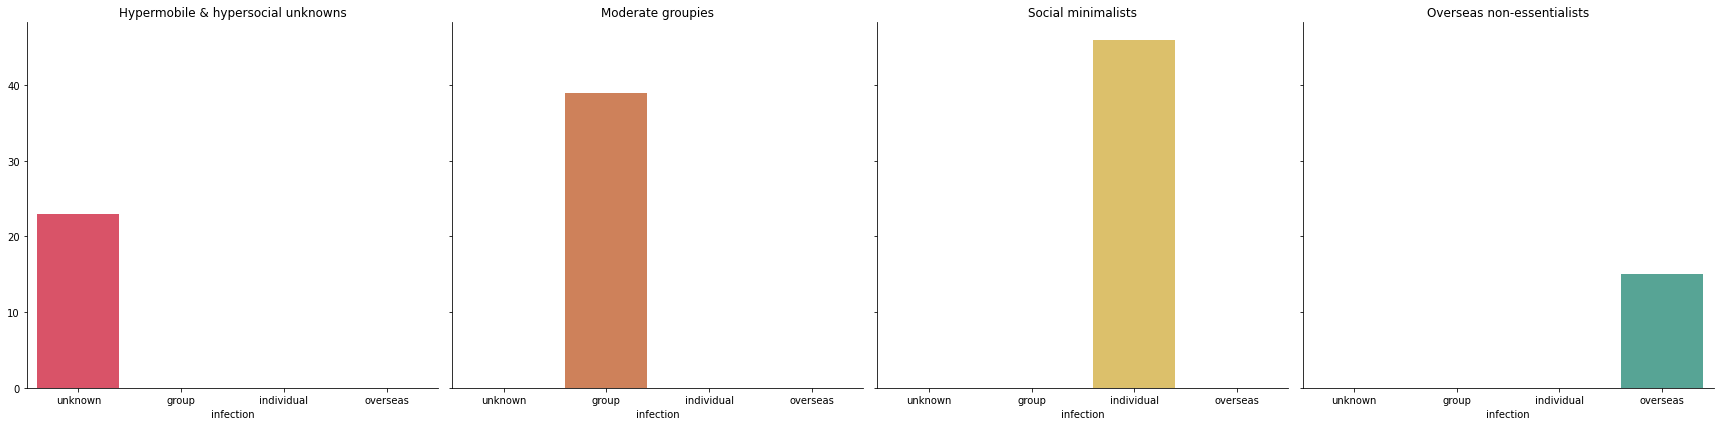

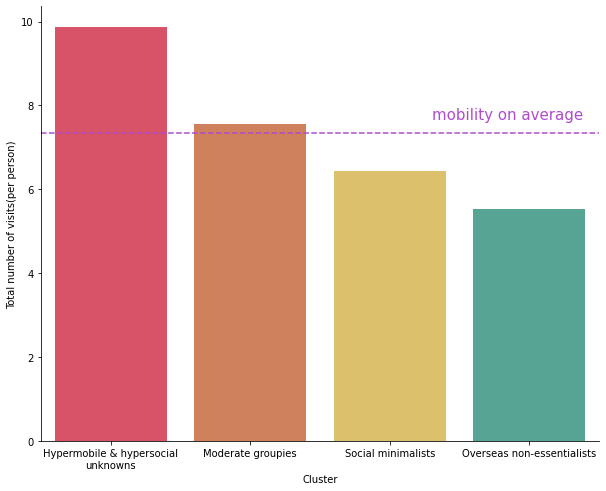

유형별 인당 총 이동 횟수를 필수이동과 부수적 이동으로 나누어 살펴 본 아래 차트를 보면,

첫번째 유형은 필수적 이동과 부수적 이동이 모두 잦았던 것으로 나타났고
두번째 유형은 첫번째 유형보다는 적지만 여전히 이동이 많고 특히 부수적 이동에서 평균보다 높은 유동성을 보였고
세번째 유형은 필수적 이동에서 평균보다 약간 높은 유동성을 보이지만 부수적 이동은 많이 하지 않았고
네번째 유형은 필수적, 부수적 이동 모두에서 평균보다 낮은 유동성을 보였습니다.

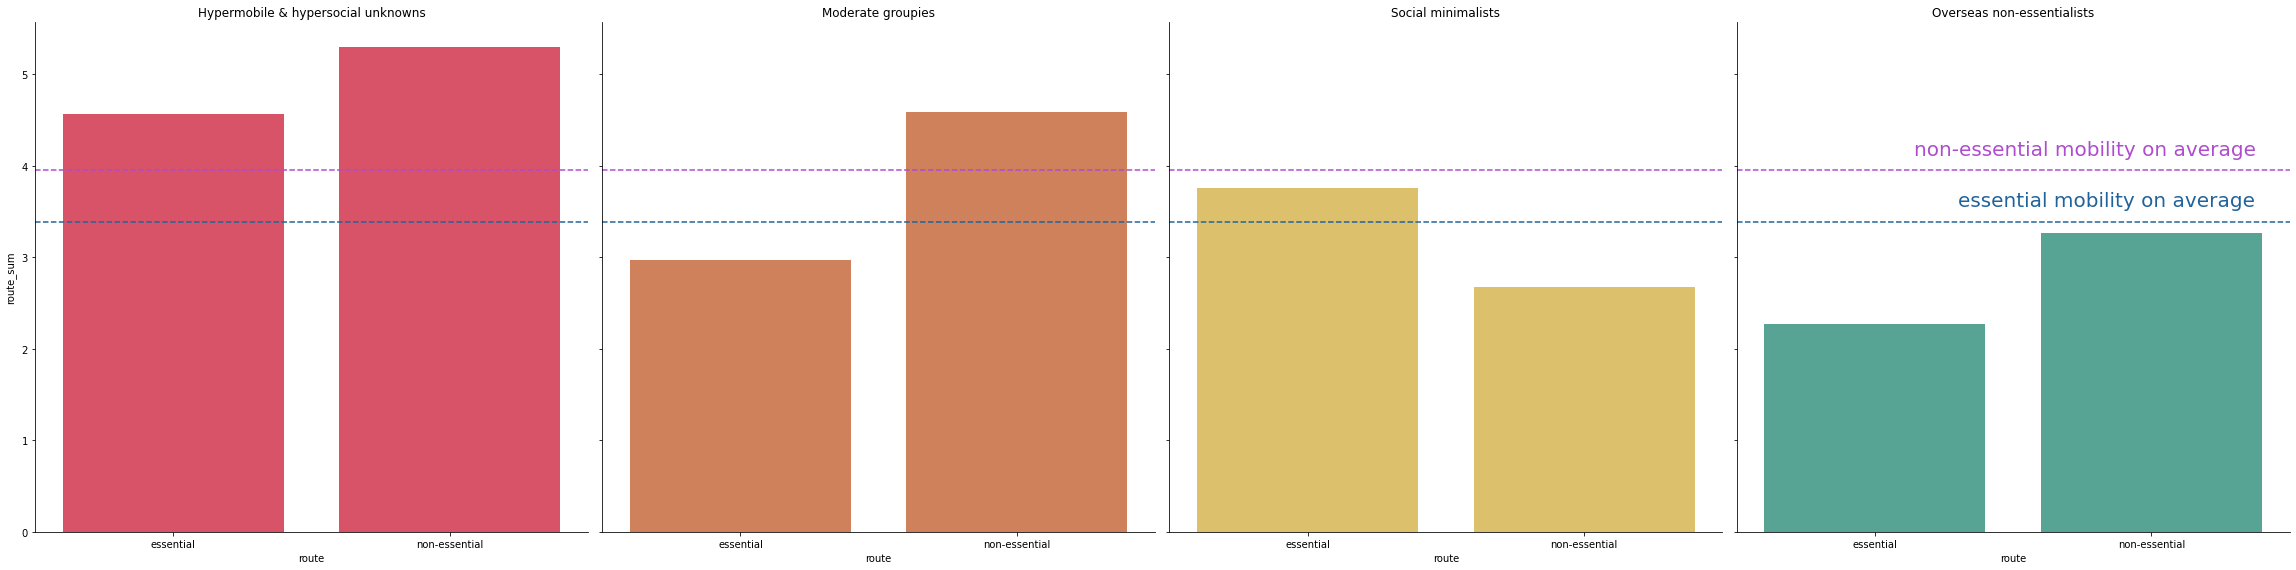

세번째로 확진자의 유형을 살펴볼 특성은 다른 사람과의 접촉 정도입니다. 아래 차트를 보면, 첫번째 유형의 접촉 정도가 가장 높고, 두번째 유형이 두번째로 높은 반면, 세번째와 네번째 유형은 훨씬 낮은 수준의 접촉 정도를 보입니다.

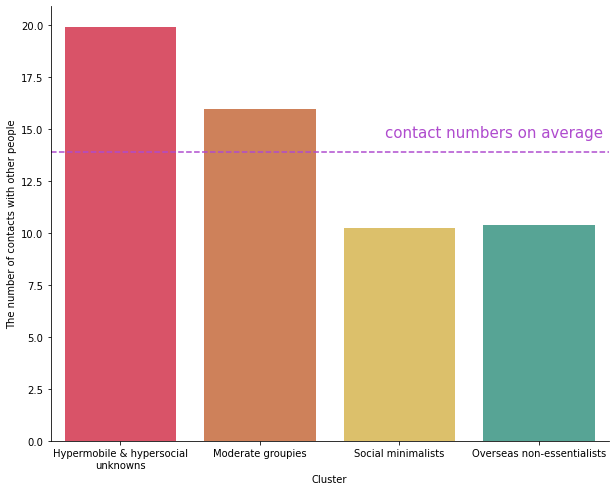

마지막으로, Cluster 모델에 활용한 마지막 행동 특성인 확진받기까지 걸린 시간을 살펴보겠습니다. 아래 차트에서 볼 수 있듯이 첫번째 유형이 확진받기까지 가장 오랜 시간이 걸린 것으로 특징지어지며, 두번째와 세번째 유형은 첫번째 유형보다는 빨리 확진을 받은 것으로 보이지만, 네번째 유형보다는 여전히 느린 수준을 나타냅니다. 네번째 유형은 확진자들의 행동 유형 중 가장 빨리 확진을 받은 것을 볼 수 있습니다. 네번째 유형은 해외 유입으로 구성된 유형으로, 해외에서 입국하면 입국 즉시 공항에서 코로나19 진단 검사를 받거나 3일 이내 보건소에서 진단 검사를 받아야하기 때문에 네번째 유형의 빠른 진단 시간은 예상 가능한 결과라고 할 수 있습니다.

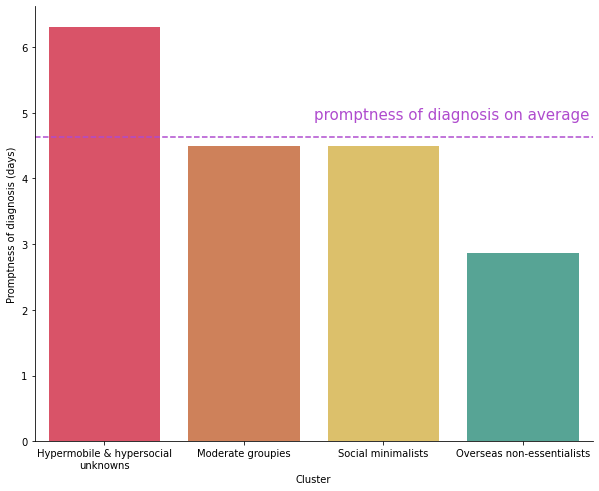


사망 위험과 관련있는 요인들을 파악하는 것이 이번 분석의 주요 목적이기 때문에 확진자의 유형별로 사망자와 회복자의 분포가 어떻게 다른지도 살펴보았습니다. 아래 차트를 보면 굉장히 흥미로운 사실을 발견할 수 있는데요. 사망자가 첫번째 유형에서만 나타난 것을 확인할 수 있습니다.

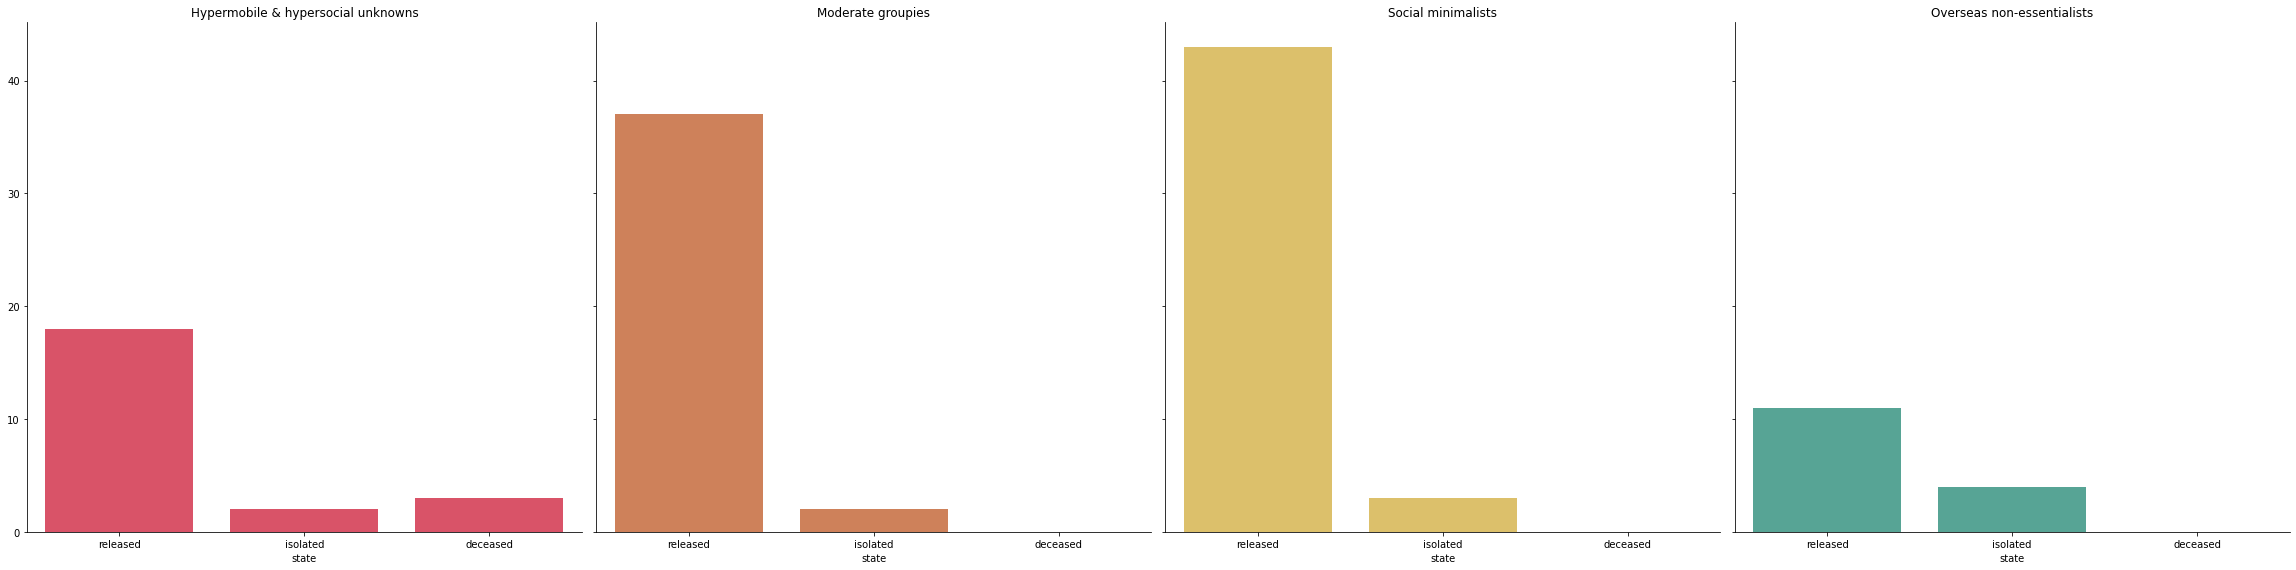

요약하면, 위의 분석으로 코로나19 확진자들의 비슷한 행동 패턴을 보인 유형 네 가지를 파악하였습니다. 각 유형을 특징지어지는 특성들에 따라 다음과 같이 명명해보았습니다.

1) Hypermobile and hypersocial unknowns
: 감염 경로가 파악되지 않은 확진자들로 높은 유동성을 보이고(필수적/부수적 이동을 많이함), 사회 활동 정도도 매우 높으며(다른 사람과의 접촉을 많이함), 증상 발현 후 확진받기까지 오랜 시간이 걸린 것으로 특징지어지는 유형. 분석 대상 중, ‘사망자’가 나타난 유일한 유형.



2) Moderate groupies
: 집단으로 감염되었으며 다른 유형보다 높은 유동성을 보이지만 Hypermobile unknowns들보다는 적은 수준의 유동성을 보인 유형. 특히 이 유형의 유동성은 부수적 이동에서 두드러짐. 사회 활동 정도 역시 Hypermobile unknowns 들보다는 적지만 나머지 두 유형보다 높은 사회 활동을 하였음. 확진받기까지 보통 수준의 시간이 걸림.



3) Social minimalists
: 개인적 접촉으로 감염된 확진자들로 위의 두 유형보다 전반적으로 유동성이 낮으며, 이동의 대부분이 필수적 이동이었던 유형. 다른 사람과의 접촉 정도가 적어 낮은 사회 활동 수준을 보임. 확진받기까지 보통 수준의 시간이 걸림.



4) Overseas non-essentialists
: 해외에서 유입된 확진자들로 다른 유형에 비해 가장 낮은 유동성을 보이지만 Social minimalists들보다 부수적 이동의 수준이 높음. 하지만 다른 사람과의 접촉이 가장 적어 많은 사회 활동은 보이지 않은 유형.

4. 코로나19 확진이 늦어지면 사망 위험도 높아질까?

위의 분석 결과에 따르면 유동성과 사회성이 가장 높은 유형은 감염 경로가 파악되지 않은 사람들이었습니다. 아마도 이들이 워낙 많은 곳을 돌아다니고 많은 사람들을 만났다보니 감염 경로를 파악하기 어려웠을 것입니다. 이들의 높은 유동성과 사회성은 확진을 빨리 받기도 어렵게 만들었습니다. 이렇게 생각해볼 수 있습니다. 많은 장소에 돌아다니며 많은 사람들을 만난 사람들은 코로나 바이러스에 노출된 장소에 갔었는지, 코로나 바이러스에 감염된 사람을 만났었는지 파악하기 어려웠을 것입니다. 그렇다면 본인이 코로나 바이러스에 노출된 것인지 정확하게 판단할 수 없었을 것이고 진단 검사를 받으러가기가 꺼려졌을 것입니다. 하지만 확진이 늦어지면 전문 치료와 관리도 지연되고 결과적으로 회복 가능성도 낮아질 것입니다.행동 특성을 기반으로 한 확진자들의 유형 중에서 유독 이 유형에서만 사망자가 나타난 것이 이때문은 아니었을까요.

물론 확진받기까지 걸린 시간과 사망 위험의 인과관계를 단언할 수는 없습니다. 하지만 PatientInfo 의 전체 표본(isloated, symptom_onset_date 결측치 제외)을 대상으로 사망/회복 별 확진받기까지 걸린 시간을 나타낸 아래 차트를 보면, 사망자들이 회복자들보다 확진받기까지 더 오래 걸린 것을 볼 수 있습니다. 사망자들의 확진 시간은 회복자들보다 평균적으로 2.5일이 더 걸렸습니다.

In [197]:
p = pd.read_csv('/content/drive/MyDrive/colab_data/PatientInfo.csv')
p = p[p['state'] != 'isolated']
p['symptom_onset_date'] = np.where(p['symptom_onset_date'] == ' ', np.nan, p['symptom_onset_date'])
p = p[(p['symptom_onset_date'].notna()) & p['confirmed_date'].notna()]
print('number of patients to be plotted:', p.shape)

number of patients to be plotted: (290, 18)


In [198]:
### Define time that lapsed between the onset of COVID-19 symptoms and the official COVID-19 diagnosis

def convert_date(x):
    '''
    The function converts string into pandas date format
    '''
    x = pd.datetime.strptime(x, '%Y-%m-%d').date()
    return x

p['symptom_onset_date'] = p['symptom_onset_date'].apply(lambda x : convert_date(x))
p['confirmed_date'] = p['confirmed_date'].apply(lambda x: convert_date(x))
p['days_notice'] = p['confirmed_date'] - p['symptom_onset_date'] 
p['hours_notice'] = p['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
p['days'] = p['hours_notice'].apply(lambda x: int(x/24))

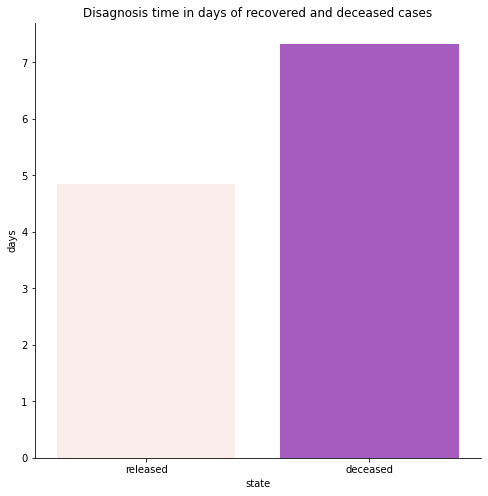

In [199]:
g = p.groupby(['state']).mean()['days']
g = pd.DataFrame(g)

plt.figure(figsize= (8,8))

ax =sns.barplot(g.index, g['days'], order = ['released', 'deceased'],
            palette = {'released': '#FCEAE6', 'deceased': '#AF4BCE'})

ax.set_title('Disagnosis time in days of recovered and deceased cases')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

display()

5. 결론 및 주요 분석 결과

이번 분석은 데이터를 보여주고 설명하는 단순 EDA를 넘어 머신러닝 알고리즘(K-means clustering)을 활용함으로써 코로나19로 인한 사망의 위험 요인을 파악하고 획기적이면서 중요한 결론에 도달하였습니다. 사실 지금까지 유동성이 높은 사람들(집에 있기보다 밖에 많이 돌아다니는 사람들)과 사회적 교류가 많은 사람들은 코로나 바이러스를 전염시킬 위험이 높다고 알려져왔습니다. 하지만 이번 분석 결과는 유동성과 사회성이 높은 사람들이 전염의 위험이 있을 뿐 아니라 이들의 행동적 특성으로 인해 본인 스스로도 코로나19의 위험에 처하게 할 수 있음을 밝혔습니다. 실제로 유동성과 사회성이 높은 유형은 사망자가 나타난 유일한 유형이었습니다.

분석 과정 중에 유동성과 사회성이 높은 유형을 다른 유형보다 사망 위험에 놓이게 하는 메카니즘에 대해 생각해보았습니다. 유동성과 사회성이 높은 유형은 코로나19의 확진을 받기까지 가장 오랜 시간이 걸리는 특징을 보였습니다(증상 발현 후 확진받기까지 네 가지 유형 중 가장 오랜 시간이 걸림). 이를 설명하기 위해 설정한 가설은 유동성이 높고 사회성이 높아 여러곳을 나다니며 많은 사람들을 만난 사람들은 본인이 바이러스에 노출된 장소에 갔었는지, 바이러스에 감염된 사람을 만났었는지 파악하기 어려웠을 것이고 따라서 코로나19 진단을 받으러 가야하는지 판단하기도 어려웠다는 것이었습니다. 확진이 늦어지면 회복에 필요한 전문적인 치료와 관리가 충분히 지원되지 못할 수도 있습니다. 물론 데이터가 제한적이기에 인과관계를 단언할 수는 없습니다. 하지만 위의 결과에서 사망자들은 회복자들보다 증상 발현 후 확진받기까지 더 오랜 시간이 걸린 것을 확인할 수 있었습니다.



5.1. 위의 분석이 코로나19 와의 전쟁에서 중요한 이유

코로나19 팬데믹(pandemic)이 진행된 동안 사회적 거리두기(social distancing)를 실천하지 않고 이곳저곳을 다니며 사회적 활동을 많이 하는 사람들은 코로나 바이러스의 감염 위험될 확률이 높을 것이라고 알려져왔습니다. 하지만 이번 분석 결과는 유동성과 사회성이 높은 사람들이 코로나 바이러스의 전염 위험을 높을 뿐만 아니라 이들의 행동적 특성으로 본인 스스로를 사망의 위험에 처하게 할 수도 있음을 제시합니다. 유동성과 사회성이 높을수록 확진을 늦게 받을 위험이 증가하고, 결과적으로 회복에 필요한 시간을 충분히 확보하지 못하게 될 수 있습니다.

제한된 데이너 내에서 늦은 확진과 사망 위험의 인과 관계를 일반화하여 단언할 수는 없습니다 - 특히 연령이 낮고 건강한 사람들은 일반적으로 시간이 지나면 스스로 회복하는 것으로 알려져있고 이들에게 확진 시간이 크게 중요하지 않을 수도 있습니다. 하지만 젊고 건강한 사람들도 본인조차 알지 못했던 기저질환이 있을 수도 있고, 생명을 살리려면 하루빨리 확진을 받고 전문적인 치료를 받아야 하는 상황에 처할 수도 있습니다. 유동성과 사회성이 높은 사람들은 진단 검사를 아예 받지 않거나, 받더라도 이미 너무 늦어버리게 될 위험에 스스로를 처하게 할 수 있습니다. 위의 분석 결과가 많은 곳을 다니고 많은 사람들을 만나는 유동성과 사회성이 높은 사람들이 단순히 다른 사람을 전염시키기 때문에 위험할 뿐 아니라 본인 스스로를 위험에 처하게 할 수 있다는 경고가 되었으면 하는 바람입니다.